In [ ]:
import tensorflow as tf
import keras
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy


from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from tensorflow.math import squared_difference
from tensorflow.math import square
from scipy.stats import norm

In [ ]:
keras.utils.set_random_seed(28)

# Hyperparameters
batch_size = 1
epochs = 5
optimizer = Adam(learning_rate=0.0075)
weight_init = RandomNormal()

xCDF = np.arange(-10, 10, 0.5)
yCDF = norm.cdf(xCDF)

# Build model
inputs = tf.keras.Input(shape=(1,))
x = Dense(512, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(inputs)
x = Dense(512, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(x)
output = Dense(1, activation='linear', kernel_initializer=weight_init)(x)
model = tf.keras.Model(inputs, output)

# function to be integrated (normal distribution PDF)
mu = 0.0
sigma = 1.0
def f_tbi(x_coloc):
    #return 2*x_coloc
    #return np.sin(x_coloc ** 2)
    return (1 / (sigma * np.sqrt(2 * math.pi)))\
          * np.exp(-0.5 * ((x_coloc - mu ) / sigma)**2)

#note here that sigma is the standard deviation (=1) in this example

# create colocation points for function to be integrated
x_coloc = np.arange(-10, 10, 0.1)  # define domain
rng = np.random.default_rng()
rng.shuffle(x_coloc)
y_coloc = f_tbi(x_coloc)

# initial condition for loss1
x_init = np.array([-10.0])
h_init = np.array([0.0])

# initial condition for loss3
x_init2 = np.array([10.0])
h_init2 = np.array([1.0])

# training step function for each batch
def step(x_co, y_co, x_init, h_init, x_init2, h_init2):
    x_co = tf.convert_to_tensor(x_co)
    x_co = tf.reshape(x_co, [batch_size, 1])  # required by keras input
    x_co = tf.Variable(x_co, name='x_co')
    with tf.GradientTape(persistent=True) as tape:

        # model_loss1: initial condition h_init @ x_init
        pred_init = model(x_init)
        model_loss1 = squared_difference(pred_init, h_init)

        # model_loss3: initial condition h_init2 @ x_init2
        pred_init2 = model(x_init2)
        model_loss3 = squared_difference(pred_init2, h_init2)

        # model_loss2: collocation points
        pred_h = model(x_co)
        dfdx = tape.gradient(pred_h, x_co)
        residual = dfdx - y_co
        model_loss2 = K.mean(square(residual), axis=-1)
        model_loss2 = tf.cast(model_loss2, tf.float32)

        #total loss
        model_loss = model_loss1 + model_loss3 + model_loss2 * 10

        trainable = model.trainable_variables
        model_gradients = tape.gradient(model_loss, trainable)

        # Update model
        optimizer.apply_gradients(zip(model_gradients, trainable))
        return np.mean(model_loss)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# Training loop
losses = []
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(x_coloc)):
        x_co_batch = x_coloc[i:i+batch_size]
        y_co_batch = y_coloc[i:i+batch_size]
        loss = step(x_co_batch, y_co_batch, x_init, h_init, x_init2, h_init2)
        total_loss += loss
    avg_loss = total_loss / len(x_coloc)
    losses.append(avg_loss)
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss}")

# Plotting the output predictions
x_test = np.linspace(-10, 10, 1000)
y_pred = model.predict(x_test)

Epoch 0, Loss: 1.4926469888247085
Epoch 1, Loss: 0.031215203936590115
Epoch 2, Loss: 0.0006896112550066391
Epoch 3, Loss: 9.702292973827298e-05
Epoch 4, Loss: 7.108420751436028e-05
32/32 [==============================] - 0s 4ms/step


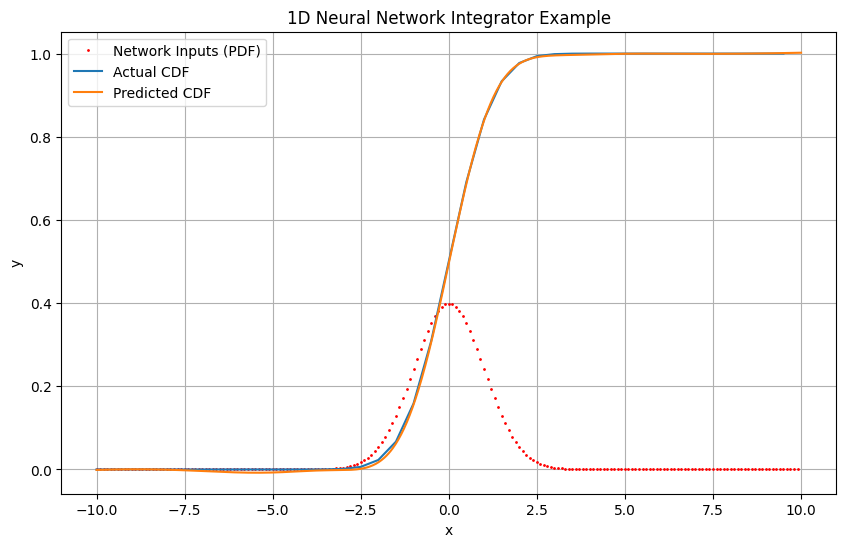

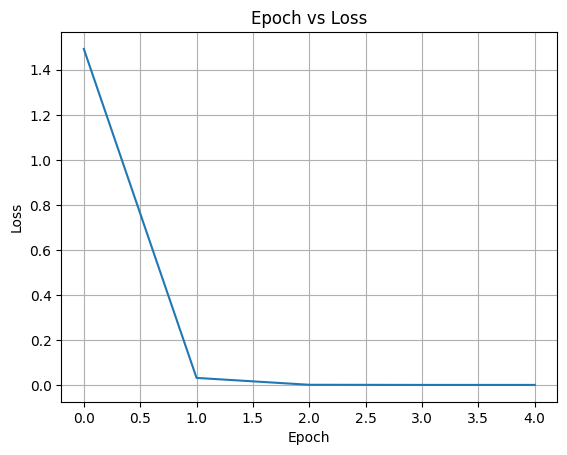

In [ ]:
#plotting network predicted CDF and the actual CDF, as well as the input colocation points
plt.figure(figsize=(10, 6))
plt.plot(x_coloc, y_coloc, "ro", label='Network Inputs (PDF)', markersize=1)
plt.plot(xCDF, yCDF, label="Actual CDF")
plt.plot(x_test, y_pred, label='Predicted CDF')
plt.xlabel('x')
plt.ylabel('y')
plt.title('1D Neural Network Integrator Example')
plt.legend()
plt.grid(True)
plt.savefig("CDFInt.png", dpi=400)
plt.show()


#loss against epoch
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.grid(True)
plt.show()

In [ ]:
#demonstrating "a priori" calculation of the symbolic integral approximation

#integral over the entire distribution (from -inf to inf)
print(model.predict([10])-model.predict([-10]))

#the probability of something being 2 standard deviations above the mean (integral from 2 to inf)
print(model.predict([10])-model.predict([2]))

#the probability above the mean
print(model.predict([10])-model.predict([0]))

1/1 [==============================] - 0s 40ms/step
[[1.0032042]]
1/1 [==============================] - 0s 37ms/step
[[0.02645886]]
1/1 [==============================] - 0s 40ms/step
[[0.5065561]]


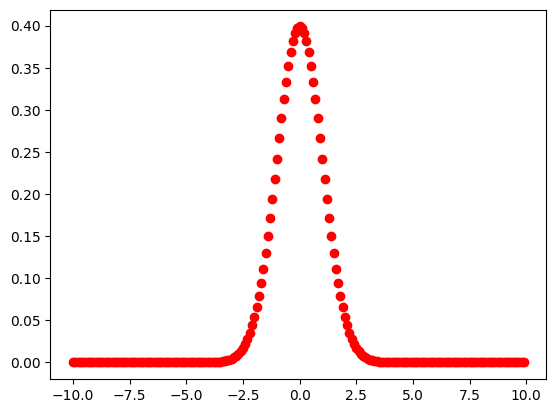

In [ ]:
plt.plot(x_coloc, y_coloc, "ro")